# 🧠🩻 DICOM Pixel & Metadata De-Identification (MIDI-B)

In this notebook, we demonstrate **end-to-end de-identification of DICOM files**, covering both **pixel data** 🖼️ and **metadata** 🧾 using **Visual NLP**, **Spark OCR**, and **Healthcare NLP** models.

The approach follows the methodology described in the blog post below, and extends it to support **full MIDI-B–compliant evaluation** across both pixel and metadata domains:

🔗 https://medium.com/john-snow-labs/de-identifying-dicom-files-a-step-by-step-guide-with-john-snow-labs-visual-nlp-2c21b60f92a8

---

## 🔍 What This Notebook Covers

The pipeline is driven by a **strategy file (CSV)** that specifies how each DICOM tag should be handled:

- 🧬 Tags marked with **`cleanTag`** are routed through **NER-based dPHI detection**
- ⚙️ All other tags are processed using **rule-based and deterministic de-identification logic**
- 🖼️ Pixel-level PHI is detected and removed using **Visual NLP–based image de-identification**

This notebook focuses on a **complete Pixel + Metadata de-identification workflow**, aligned with the  
**MIDI-B (Medical Image De-Identification Benchmark)** guidelines.

---

## 📘 Notebook Workflow

The notebook is organized into the following steps:

### 1️⃣ Load DICOM Files  
📂 Read and inspect raw DICOM files (single-frame and multi-frame) from disk.

### 2️⃣ View Strategy Files  
📄 Examine the CSV strategy file that defines:
- Tag-level metadata actions  
- Pixel-level de-identification behaviour  

### 3️⃣ Run Pixel + Metadata De-Identification Pipeline  
🚀 Apply the combined pipeline to:
- Remove PHI from image pixels  
- Clean or transform sensitive metadata tags  
- Preserve required clinical and technical information  

### 4️⃣ Compare Original vs De-Identified Outputs  
🔎 Analyse differences between:
- Original vs cleaned metadata  
- Original vs de-identified pixel regions  

### 5️⃣ Extract PATIENT / UID Mappings  
🔗 Generate deterministic mappings to support:
- Longitudinal consistency  
- Controlled re-identification (when permitted)  
- MIDI-B validation  

### 7️⃣ Save De-Identified DICOMs to Disk  
💾 Persist fully de-identified DICOM files for downstream use, benchmarking, or deployment.

In [1]:
license = ""
secret = ""
nlp_secret = ""
aws_access_key = ""
aws_secret_key = ""

version = secret.split("-")[0]
spark_ocr_jar_path = "../../../target/scala-2.12"

## Start Spark session

In [2]:
from sparkocr import start
import os 

if license:
    os.environ['JSL_OCR_LICENSE'] = license
    os.environ['SPARK_NLP_LICENSE'] = license

if aws_access_key:
    os.environ['AWS_ACCESS_KEY'] = aws_access_key
    os.environ['AWS_SECRET_ACCESS_KEY'] = aws_secret_key

extra_configurations = {
    "spark.extraListeners": "com.johnsnowlabs.license.LicenseLifeCycleManager"
}

spark = start(secret=secret,
              nlp_secret=nlp_secret,
              jar_path=spark_ocr_jar_path,
              nlp_internal="6.2.2",
              extra_conf=extra_configurations)

spark

Spark version: 3.5.0
Spark NLP version: 6.2.0
Spark NLP for Healthcare version: 6.2.2
Spark OCR version: 6.2.2

:: loading settings :: url = jar:file:/usr/local/lib/python3.11/dist-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-3a2925cf-1ab9-43f9-9126-5437973423a7;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp_2.12;6.2.2 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 in central
	found com.g

## Import transformers and annotators

In [3]:
import os
import sys
import shutil 

from sparknlp.annotator import *
from sparknlp.base import *
import sparknlp_jsl
from sparknlp_jsl.annotator import *

import sparkocr
from sparkocr.transformers import *
from sparkocr.utils import *
from sparkocr.enums import *
from sparkocr.schemas import BinarySchema

from pyspark.ml import PipelineModel, Pipeline
from pyspark.sql.functions import *

print(f"Spark NLP version: {sparknlp.version()}")
print(f"Spark NLP internal version: {sparknlp_jsl.version()}")
print(f"Spark OCR version: {sparkocr.version()}")

Spark NLP version: 6.2.0
Spark NLP internal version: 6.2.2
Spark OCR version: 6.2.2


## Load Dicom Files

In [4]:
midib_root_path = './../data/dicom/midib/*.dcm'

dicom_df = spark.read.format("binaryFile").load(midib_root_path)

dicom_df

+--------------------+-------------------+-------+--------------------+
|                path|   modificationTime| length|             content|
+--------------------+-------------------+-------+--------------------+
|file:/workspace/w...|2026-01-23 16:54:29|8179050|[00 00 00 00 00 0...|
|file:/workspace/w...|2026-01-23 16:54:29|7022298|[00 00 00 00 00 0...|
+--------------------+-------------------+-------+--------------------+

## Load Strategy File

In [5]:
import pkg_resources
import pandas as pd

default_csv_path = pkg_resources.resource_filename('sparkocr', "resources/ocr/dicom/midi_b_strategy_ner.csv")

strategy_df = pd.read_csv(default_csv_path)

strategy_df.head()

/tmp/ipykernel_25341/3087510468.py:1: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  import pkg_resources


Tags  VR                                 Name Status  \
0  (0008, 002A)  DT                 Acquisition DateTime    NaN   
1  (0008, 009C)  PN          Consulting Physician's Name    NaN   
2  (0008, 010D)  UI  Context Group Extension Creator UID    NaN   
3  (0010, 21D0)  DA                  Last Menstrual Date    NaN   
4  (0010, 21F0)  LO       Patient's Religious Preference    NaN   

                      Action Option  
0  shiftDateByRandomNbOfDays    NaN  
1                     remove    NaN  
2                     hashId    NaN  
3  shiftDateByRandomNbOfDays    NaN  
4                     remove    NaN

In [6]:
# all available actions in the present strategy file
strategy_df[["Action"]].drop_duplicates()

Action
0    shiftDateByRandomNbOfDays
1                       remove
2                       hashId
11       replaceWithRandomName
65    shiftUnixTimeStampRandom
68          replaceWithLiteral
72                    cleanTag
103            ensureTagExists
148              patientHashId

# Dicom ( Pixel + Metadata ) De-Identification

### 🧾 DICOM Metadata De-Identification Pipeline

This section describes the **metadata-level de-identification pipeline** used to detect and remove **PHI embedded in DICOM metadata tags**.  
The pipeline combines **strategy-driven tag routing**, **Healthcare NLP**, **Zero-Shot NER**, and **rule-based pattern matching** to identify sensitive entities and generate **cleaned, PHI-safe metadata** while preserving DICOM structural integrity.

The behavior of the pipeline is fully controlled by a **strategy file (CSV)**, enabling configurable, auditable, and repeatable metadata de-identification.

---

#### ⚙️ Pipeline Overview

The metadata de-identification pipeline performs the following high-level steps:

1. Extract DICOM metadata from files
2. Route selected tags for NLP-based PHI detection using a strategy file
3. Convert tag text into NLP-ready documents
4. Detect PHI using deep-learning NER, zero-shot NER, and regex rules
5. Merge and filter detected PHI entities
6. Obfuscate sensitive metadata values and reconstruct cleaned metadata

The final output consists of **de-identified metadata representations** that can be written back into valid DICOM files.

In [7]:
def metadata_deid_pipeline(default_csv_path):
    
    dicom_to_metadata = DicomToMetadata() \
        .setInputCol("content") \
        .setOutputCol("metadata_original") \
        .setKeepInput(False) \
        .setExtractTagForNer(True) \
        .setTagMappingCol("tag_mapping") \
        .setTagCol("tag_text") \
        .setStrategyFile(default_csv_path)
    
    t_document_assembler = DocumentAssembler() \
        .setInputCol("tag_text") \
        .setOutputCol("t_document")
    
    t_sentencer = SentenceDetector()\
        .setInputCols(["t_document"])\
        .setOutputCol("t_sentence") \
        .setCustomBounds(["<dicom>"]) \
        .setUseCustomBoundsOnly(True)
    
    t_tokenizer = Tokenizer() \
        .setInputCols(["t_sentence"]) \
        .setOutputCol("t_token") \
        .setContextChars(["_", "^", "."])
    
    t_word_embeddings = WordEmbeddingsModel.pretrained("embeddings_clinical", "en", "clinical/models") \
        .setInputCols(["t_sentence", "t_token"]) \
        .setOutputCol("t_embeddings")
    
    t_ner_deidentify_dl = MedicalNerModel.pretrained("ner_deidentify_dl", "en", "clinical/models") \
        .setInputCols("t_sentence", "t_token", "t_embeddings") \
        .setOutputCol("t_ner_deidentify_dl")
    
    t_ner_deidentify_dl_ner_converter = NerConverterInternal() \
        .setInputCols(["t_sentence", "t_token", "t_ner_deidentify_dl"]) \
        .setOutputCol("t_ner_deidentify_dl_ner_chunk") \
        .setWhiteList(["DOCTOR", "PATIENT", "ORGANIZATION", "LOCATION-OTHER", "COUNTRY", "CITY", "STATE", "STREET", "ZIP"]) \
        .setThreshold(0.82)
    
    labels = ["CITY", "COUNTRY", "DATE", "DOCTOR", "HOSPITAL", "ORGANIZATION", "PATIENT", "PHONE", "PROFESSION", "STATE", "STREET", "ZIP"]
    t_zeroshot_ner_deid_subentity_docwise_large = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_large", "en", "clinical/models") \
        .setInputCols("t_sentence", "t_token") \
        .setOutputCol("t_zeroshot_ner_deid_subentity_docwise_large") \
        .setPredictionThreshold(0.90) \
        .setLabels(labels)
    
    t_zeroshot_ner_deid_subentity_docwise_large_ner_converter = NerConverterInternal()\
        .setInputCols("t_sentence", "t_token", "t_zeroshot_ner_deid_subentity_docwise_large")\
        .setOutputCol("t_zeroshot_ner_deid_subentity_docwise_large_ner_chunk")
    
    codes = [
        "AK","TSARH","BH","FGH","PH","WGMC","GVH","MCH","MJM","SS","CWASH","RASC","CMCH","FMCC",
        "TLM","RMABCH","EBMC","MM","SCH","WM","AAARM","HM","WHAYCC","BGH","NH","MDCH","DSAPCC",
        "MBARCH","CMC","MLASGH","FWARMC","GFASCC","JCH","MKAAH","WNGH","PAAHMC","WBARCC","HG",
        "WG","HMCC","CHC","HCCH","CHAJH","PQACH","MSCH","MJH","HMAJMC","DHCH","GGAMH","LGMC",
        "HRG","HGAWC","WJADC","DC","LCH","WSC","BJAHGH","SSABM","HSG","HHAMM","BGCC","JASGH",
        "HWGH","AMC","KM","RS","DL","CL","LS","KP","CV","AR","CB","SE","ES","JD","CCH","DBAMCH",
        "MSAMM","SBAJH","RTAJCC","BASM","VHG","HPCC","HPAOM","AL","RD","CW","DTAMG","SCASM",
        "HFACG","YPH","MWM","SL","SW","VAGH","SJ", "AH", "CH", "JCASCH", "LBAWCH","ECC", "NRALG",
        "MWG", "WBAACH", "FBH", "CAAFMC", "BYARMC"
    ]
    
    pattern = r"\b(" + "|".join(codes) + r")\b"
    
    t_regex_matcher = RegexMatcher() \
        .setInputCols("t_sentence") \
        .setOutputCol("t_regex") \
        .setRules([
            # Match known hospital or facility codes (from predefined list)
            pattern + ";CODES",
            # Match professional titles like Dr., DR., dr
            r"\b[Dd][Rr]\b\.?;PROFESSION",
            # Match numeric IDs in format: 123.456.7890x123
            r"\d{3}\.\d{3}\.\d{4}x\d{3};ID",
            # Match compact date-like numeric patterns (YYMMDD etc.)
            r"\b(?:\d{2}(0[1-9]|1[0-2])(0[1-9]|[12]\d|3[01]))\b;DATE",
            # Match phone-like pattern with parentheses and extension,
            # e.g. (151)265-4464x20 — but we tag it as DATE as per your request
            r"\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}(?:x\d{1,5})?;PHONE",
            # Match SSN-style numeric pattern (e.g. 300-45-3175) → labeled as DATE
            r"\b\d{3}-\d{2}-\d{4}\b;DATE"]) \
        .setDelimiter(";") 
    
    t_chunk_converter = ChunkConverter()\
        .setInputCols("t_regex")\
        .setOutputCol("t_regex_ner_chunk")
    
    t_chunk_merger = ChunkMergeApproach()\
        .setInputCols('t_regex_ner_chunk', 't_ner_deidentify_dl_ner_chunk', 't_zeroshot_ner_deid_subentity_docwise_large_ner_chunk')\
        .setOutputCol('t_merged_ner_chunk')\
        .setMergeOverlapping(True)
    
    filter_chunk = ["US", "MR BREAS", "MR BREAST BILAT", "MR BREASTUNI", "MIEDNICA", "WWO", "THINS", 
          "3D Rendering", "MAMMO", "CT", "DCE", "CA", "MC prostaat kliniek detectie-mc"]
    
    t_chunk_filterer = ChunkFilterer() \
      .setInputCols(["t_sentence","t_merged_ner_chunk"]) \
      .setOutputCol("t_filtered") \
      .setCriteria("isin") \
      .setFilterValue("result") \
      .setBlackList(filter_chunk)
    
    deid_obfuscated = DeIdentification() \
        .setInputCols(["t_sentence", "t_token", "t_filtered"]) \
        .setOutputCol("deid_documents") \
        .setMode("deid")
    
    pipeline = Pipeline(stages=[
        dicom_to_metadata,
        t_document_assembler,
        t_sentencer,
        t_tokenizer,
        t_word_embeddings,
        t_ner_deidentify_dl,
        t_ner_deidentify_dl_ner_converter,
        t_zeroshot_ner_deid_subentity_docwise_large,
        t_zeroshot_ner_deid_subentity_docwise_large_ner_converter,
        t_regex_matcher,
        t_chunk_converter,
        t_chunk_merger,
        t_chunk_filterer,
        deid_obfuscated
    ])

    return pipeline

### 🖼️ DICOM Pixel De-Identification Pipeline

This section describes the **pixel-level de-identification pipeline** used to detect and remove **PHI embedded directly in DICOM image pixels**. The pipeline combines **Visual NLP**, **OCR**, **Zero-Shot NER**, and **rule-based pattern matching** to accurately localize sensitive information and return precise pixel coordinates for redaction.

The pipeline supports **CPU and GPU execution**, enabling scalable processing across large imaging datasets.

---

#### ⚙️ Pipeline Overview

The pixel de-identification pipeline performs the following high-level steps:

1. Convert DICOM files into images
2. Detect text regions within the image
3. Extract text with positional information (OCR)
4. Identify PHI entities using NER and regex rules
5. Map detected PHI entities back to image coordinates

In [8]:
def ocr_extraction_pipeline(scale, useGPU):

    dicom_to_image = DicomToImageV3() \
        .setInputCols(["content"]) \
        .setOutputCol("image_raw") \
        .setKeepInput(False) \
        .setScale(scale)
    
    text_detector = ImageTextDetector.pretrained("image_text_detector_mem_opt", "en", "clinical/ocr") \
        .setInputCol("image_raw") \
        .setOutputCol("text_regions") \
        .setScoreThreshold(0.7) \
        .setWithRefiner(True) \
        .setUseGPU(useGPU) \
        .setWidth(0)
    
    ocr = ImageToTextV2.pretrained("ocr_large_printed_v2_opt", "en", "clinical/ocr") \
        .setRegionsColumn("text_regions") \
        .setInputCols(["image_raw"]) \
        .setOutputCol("text") \
        .setOutputFormat("text_with_positions") \
        .setGroupImages(False) \
        .setKeepInput(False) \
        .setUseGPU(useGPU) \
        .setUseCaching(True)

    pipeline = Pipeline(stages=[
        dicom_to_image,
        text_detector,
        ocr
    ])

    return pipeline

In [9]:
def pixel_deid_pipeline(scale, useGPU, outputPartition):
    
    p_document_assembler = DocumentAssembler() \
        .setInputCol("text") \
        .setOutputCol("p_document") \
        .setCleanupMode("disabled")
    
    p_sentencer = SentenceDetector()\
        .setInputCols(["p_document"])\
        .setOutputCol("p_sentence") \
        .setCustomBounds(["\n"]) \
        .setUseCustomBoundsOnly(False)
    
    p_tokenizer = Tokenizer() \
        .setInputCols(["p_sentence"]) \
        .setOutputCol("p_token")
    
    labels = ["DATE", "DOCTOR", "PATIENT"]
    p_zeroshot_ner_deid_subentity_docwise_medium = PretrainedZeroShotNER().pretrained("zeroshot_ner_deid_subentity_docwise_medium", "en", "clinical/models")\
        .setInputCols("p_sentence", "p_token")\
        .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium")\
        .setPredictionThreshold(0.5)\
        .setLabels(labels)
    
    p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter = NerConverterInternal()\
        .setInputCols("p_sentence", "p_token", "p_zeroshot_ner_deid_subentity_docwise_medium")\
        .setOutputCol("p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk") \
        .setThreshold(0.80)
    
    p_regex_matcher = RegexMatcher()\
        .setInputCols("p_document")\
        .setOutputCol("p_regex")\
        .setRules([
            r"\[\s*([MFU])\s*\](?:\s|\b|$);GENDER",
            r"\b(?:JT|SWU|JKR|MWF|ICG|NKF|YH|TJN|LEITO|ACO|CEF|CMS|JGR|MSS|MHS|ROC|LM|RCN|FTA|MGO|LACI|VV|HA|TR|CJA)\b;CODE"]) \
        .setDelimiter(";")
    
    p_chunk_converter = ChunkConverter()\
        .setInputCols("p_regex")\
        .setOutputCol("p_regex_chunk")
    
    p_chunk_merger = ChunkMergeApproach()\
        .setInputCols('p_regex_chunk', "p_zeroshot_ner_deid_subentity_docwise_medium_ner_chunk")\
        .setOutputCol('p_merged_ner_chunk')\
        .setMergeOverlapping(True)
    
    position_finder = PositionFinder() \
        .setInputCols("p_merged_ner_chunk") \
        .setOutputCol("coordinates") \
        .setPageMatrixCol("positions") \
        .setSmoothCoordinates(True) \
        .setIgnoreSchema(True)

    draw_regions = DicomDrawRegions() \
        .setInputCol("path") \
        .setInputRegionsCol("coordinates") \
        .setOutputCol("dicom_pixel_cleaned") \
        .setAggCols(["path"]) \
        .setKeepInput(True) \
        .setRegionType(RegionType.Coordinate) \
        .setScaleFactor(1 / scale) \
        .setOutputPartitionSize(outputPartition)
    
    pipeline = Pipeline(stages=[
        p_document_assembler,
        p_sentencer,
        p_tokenizer,
        p_zeroshot_ner_deid_subentity_docwise_medium,
        p_zeroshot_ner_deid_subentity_docwise_medium_ner_converter,
        p_regex_matcher,
        p_chunk_converter,
        p_chunk_merger,
        position_finder,
        draw_regions
    ])

    return pipeline

<h3>🏁 De-Identification Finisher Stage</h3>

<p>
  This is the <strong>final stage of the de-identification pipeline</strong>, where all required signals from
  metadata analysis and pixel-level processing are consolidated to produce a fully compliant output.
</p>

<p>
  At this point, <strong>all PHI detection and localization steps are already complete</strong>. The finisher
  focuses on assembling the final artifacts rather than performing any additional detection.
</p>

<ul>
  <li>
    <strong>Metadata de-identification output</strong> is available in the
    <code>deid_document</code> column, containing the finalized, policy-compliant metadata values.
  </li>
  <li>
    <strong>Pixel-level PHI has already been removed</strong>, and a new reconstructed DICOM file with
    de-identified pixels is produced in the <code>dicom_pixel_cleaned</code> column.
  </li>
  <li>
    The pipeline also extracts both <strong>metadata_original</strong> and <strong>metadata_final</strong>.
  </li>
</ul>


In [10]:
def finisher_pipeline(default_csv_path):

    dicom_deidentifier = DicomMetadataDeidentifier() \
        .setInputCols(["dicom_pixel_cleaned"]) \
        .setOutputCol("dicom_metadata_cleaned") \
        .setTagMappingCol("tag_mapping") \
        .setKeepInput(False) \
        .setTagCleanedCol("deid_documents") \
        .setStrategyFile(default_csv_path)

    original_metadata = DicomToMetadata() \
        .setInputCol("path") \
        .setOutputCol("metadata_original") \
        .setKeepInput(True) \
        .setExtractTagForNer(False)

    deid_metadata = DicomToMetadata() \
        .setInputCol("dicom_metadata_cleaned") \
        .setOutputCol("metadata_final") \
        .setKeepInput(True) \
        .setExtractTagForNer(False)

    pipeline = Pipeline(stages=[
        dicom_deidentifier,
        original_metadata,
        deid_metadata
    ])

    return pipeline

<h3>🔗 End-to-End De-Identification Pipeline Overview</h3>

<p>
  The de-identification workflow is composed of multiple specialized pipelines, each responsible for
  a distinct stage of metadata and pixel-level processing. Together, they produce a fully
  de-identified, standards-compliant DICOM output.
</p>

<h4>📄 Metadata De-Identification Pipeline</h4>
<p>
  The <code>metadata_deid_pipeline</code> extracts metadata from the input DICOM files and applies
  NER-based detection to identify PHI within tag values.
</p>
<ul>
  <li>
    Performs NER detection on DICOM metadata
  </li>
  <li>
    Generates de-identified values for all tags marked with the
    <code>cleanTag</code> action in the strategy file
  </li>
  <li>
    Produces the finalized metadata output in the
    <code>deid_documents</code> column
  </li>
</ul>

<h4>🧾 OCR Extraction Pipeline</h4>
<p>
  The <code>ocr_extraction_pipeline</code> operates on the DICOM pixel data to extract textual content
  embedded within images.
</p>
<ul>
  <li>
    Loads the DICOM file and extracts image frames
  </li>
  <li>
    Performs text detection to locate regions containing text
  </li>
  <li>
    Applies OCR to extract text along with spatial position information
  </li>
  <li>
    Outputs <strong>text</strong> and corresponding <strong>positions</strong> for downstream processing
  </li>
</ul>

<h4>🖼️ Pixel De-Identification Pipeline</h4>
<p>
  The <code>pixel_deid_pipeline</code> builds on the OCR outputs to identify and remove PHI present
  directly in image pixels.
</p>
<ul>
  <li>
    Consumes extracted text and positional coordinates
  </li>
  <li>
    Performs NER detection and coordinate generation for PHI entities
  </li>
  <li>
    Masks pixel regions where PHI is detected
  </li>
  <li>
    Generates a de-identified pixel-level DICOM file in the
    <code>dicom_pixel_cleaned</code> column
  </li>
</ul>

<h4>🏁 Finisher Pipeline</h4>
<p>
  The <code>finisher_pipeline</code> consolidates results from both metadata and pixel pipelines to
  produce the final output.
</p>
<ul>
  <li>
    Loads the <code>dicom_pixel_cleaned</code> output from the pixel de-identification pipeline
  </li>
  <li>
    Loads the <code>deid_documents</code> tag mappings from the metadata de-identification pipeline
  </li>
  <li>
    Joins both results based on the DICOM <code>path</code>
  </li>
  <li>
    Applies metadata de-identification to generate the final
    <code>dicom_metadata_cleaned</code> output
  </li>
  <li>
    Extracts and retains both <strong>original</strong> and <strong>final</strong> metadata values for
    validation, auditing, and reporting
  </li>
</ul>

In [11]:
scale = 0.75 # Scale the Image down to 75%
use_gpu = False # Run Text Detection, Text Extraction, and NER Detection on GPU/CPU

# Output Partition Size post DicomDrawRegions
unique_files = dicom_df.select("path").distinct().count()

tag_pipe = metadata_deid_pipeline(default_csv_path)

ocr_pipe = ocr_extraction_pipeline(scale, use_gpu)

pixel_pipe = pixel_deid_pipeline(scale, use_gpu, unique_files)

finisher_pipe = finisher_pipeline(default_csv_path)

embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
[ | ]embeddings_clinical download started this may take some time.
Approximate size to download 1.6 GB
Download done! Loading the resource.
[OK!]
ner_deidentify_dl download started this may take some time.
Approximate size to download 14.1 MB
[ / ]ner_deidentify_dl download started this may take some time.
Approximate size to download 14.1 MB
Download done! Loading the resource.
[ — ]

2026-01-23 17:34:10.795539: I external/org_tensorflow/tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-23 17:34:10.888279: W external/org_tensorflow/tensorflow/core/common_runtime/colocation_graph.cc:1218] Failed to place the graph without changing the devices of some resources. Some of the operations (that had to be colocated with resource generating operations) are not supported on the resources' devices. Current candidate devices are [
  /job:localhost/replica:0/task:0/device:CPU:0].
See below for details of this colocation group:
Colocation Debug Info:
Colocation group had the following types and supported devices: 
Root Member(assigned_device_name_index_=-1 requested_device_name_='/device:GPU:0' assigned_de

[OK!]
zeroshot_ner_deid_subentity_docwise_large download started this may take some time.
Approximate size to download 1.5 GB
[ | ]zeroshot_ner_deid_subentity_docwise_large download started this may take some time.
Approximate size to download 1.5 GB
Download done! Loading the resource.
[OK!]
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
image_text_detector_mem_opt download started this may take some time.
Approximate size to download 77.5 MB
Download done! Loading the resource.


ocr_large_printed_v2_opt download started this may take some time.
Approximate size to download 931 MB
Download done! Loading the resource.
zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
[ | ]zeroshot_ner_deid_subentity_docwise_medium download started this may take some time.
Approximate size to download 678.7 MB
Download done! Loading the resource.
[OK!]
No error


<h2>Checkpoint Result Path</h2>

In [12]:
tag_res_path = "./dicom_pixels_ner/tag"
ocr_res_path = "./dicom_pixels_ner/ocr"
pixel_res_path = "./dicom_pixels_ner/pixel"
final_res_path = "./dicom_pixels_ner/final"

<h3>🧪 End-to-End Example (Pipeline Execution)</h3>

<pre><code>
tag_deid_result = tag_pipe.fit(dicom_df).transform(dicom_df).select("path", "tag_mapping", "deid_documents")
tag_deid_result.write.format("parquet").mode("overwrite").save(tag_res_path)

ocr_deid_result = ocr_pipe.fit(dicom_df).transform(dicom_df)
ocr_deid_result.write.format("parquet").mode("overwrite").save(ocr_res_path)

ocr_result = spark.read.format("parquet").load(ocr_res_path)

pixel_deid_result = pixel_pipe.fit(ocr_result).transform(ocr_result)
pixel_deid_result.write.format("parquet").mode("overwrite").save(pixel_res_path)

pixel_deid_df = spark.read.format("parquet").load(pixel_res_path)
tag_deid_df = spark.read.format("parquet").load(tag_res_path)

combined_res = pixel_deid_df.join(tag_deid_df, "path", "inner")

final_res = finisher_pipe.fit(combined_res).transform(combined_res)
final_res.write.format("parquet").mode("overwrite").save(final_res_path)
</code></pre>

<h2>📄 Metadata De-Identification Pipeline</h2>

In [13]:
# Call Tag DeIdentification Pipeline
tag_deid_result = tag_pipe.fit(dicom_df).transform(dicom_df).select("path", "tag_mapping", "deid_documents")
tag_deid_result.write.format("parquet").mode("overwrite").save(tag_res_path)

/usr/local/lib/python3.11/dist-packages/pyspark/sql/dataframe.py:168: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
17:34:52, INFO Run DicomToMetadata                                  (0 + 2) / 2]
17:34:52, INFO Run DicomToMetadata
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.3.185.0.2.0801206.6.512.1221786140775342924'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.3.185.0.2.0801206.6.512.1530417802811153775'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: User

Using CPUs


In [14]:
tag_deid_df = spark.read.format("parquet").load(tag_res_path)
tag_deid_df.columns

['path', 'tag_mapping', 'deid_documents']

In [15]:
tag_deid_df.select(F.explode("deid_documents")).show(10, False)

+---------------------------------------------------------------------------------------------------------+
|col                                                                                                      |
+---------------------------------------------------------------------------------------------------------+
|{document, 0, 18, CHEST, PA & LATERAL, {sentence -> 0, originalIndex -> 0}, []}                          |
|{document, 19, 34, Performed <DATE>, {sentence -> 1, originalIndex -> 26}, []}                           |
|{document, 35, 77, Ordered for <DATE> by <PROFESSION> <DOCTOR>, {sentence -> 2, originalIndex -> 51}, []}|
|{document, 0, 11, CHEST 2 VIEW, {sentence -> 0, originalIndex -> 0}, []}                                 |
|{document, 12, 23, CHEST 2 VIEW, {sentence -> 1, originalIndex -> 19}, []}                               |
+---------------------------------------------------------------------------------------------------------+



<h2>🧾 OCR Extraction Pipeline</h2>

In [16]:
ocr_deid_result = ocr_pipe.fit(dicom_df).transform(dicom_df)
ocr_deid_result.write.format("parquet").mode("overwrite").save(ocr_res_path)

17:35:07, INFO Run DicomToImageV3
17:35:07, INFO DicomToImageV3: Number of frames: 1
17:35:07, INFO DicomToImageV3: Number of frames To Extract: 0
17:35:07, INFO DicomToImageV3: Extracting All Frames.
17:35:07, INFO Run DicomToImageV3
17:35:07, INFO DicomToImageV3: Number of frames: 1
17:35:07, INFO DicomToImageV3: Number of frames To Extract: 0
17:35:07, INFO DicomToImageV3: Extracting All Frames.
17:35:08, INFO Error during overlay extraction: Traceback (most recent call last):
File "/usr/local/lib/python3.11/dist-packages/sparkocr/transformers/dicom/dicom_to_image_v3.py", line 239, in add_image
arr = arr + ds.overlay_array(0x6000)
^^^^^^^^^^^^^^^^^^^^^^^^
return get_overlay_array(self, group)
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
raise AttributeError(
AttributeError: Unable to convert the overlay data as the following required elements are missing from the dataset: OverlayData, OverlayBitsAllocated, OverlayRows, OverlayColumns
17:35:08, INFO Error during overlay extraction: Traceback (most

In [17]:
# Reload results from disk

ocr_result = spark.read.format("parquet").load(ocr_res_path)
ocr_result.columns

['pagenum',
 'frame_dims',
 'path',
 'modificationTime',
 'length',
 'text_regions',
 'text',
 'confidence',
 'positions',
 'exception']

In [18]:
ocr_result.select("text").show(10, False)

+-----------------------------------------------------+
|text                                                 |
+-----------------------------------------------------+
|EDWARDS WILLIAM [M] 05.26.2019\nDOB: 03.26.1938\nLITO|
|L:\nONEAL DARRELL [U] 04.13.2012\nDOB: 02.19.1940    |
+-----------------------------------------------------+



<h2>🖼️ Pixel De-Identification Pipeline</h2>

In [19]:
pixel_deid_result = pixel_pipe.fit(ocr_result).transform(ocr_result)
pixel_deid_result.write.format("parquet").mode("overwrite").save(pixel_res_path)

Using CPUs


17:35:41, INFO DicomDrawRegions: file:/workspace/workshop/visual-nlp-workshop/jupyter/data/dicom/midib/TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714.0.0.7426654.9.695.1102170333010371365___1-1.dcm Origin size: 7022298
17:35:41, WARNING DicomDrawRegions: file:/workspace/workshop/visual-nlp-workshop/jupyter/data/dicom/midib/TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714.0.0.7426654.9.695.1102170333010371365___1-1.dcm Dicom does not contain NumberOfFrames Tag Assuming value to be 1.
17:35:41, INFO DicomDrawRegions: file:/workspace/workshop/visual-nlp-workshop/jupyter/data/dicom/midib/TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714.0.0.7426654.9.695.1102170333010371365___1-1.dcm Photometric Interpretation: MONOCHROME2
17:35:41, INFO DicomDrawRegions: file:/workspace/workshop/visual-nlp-workshop/jupyter/data/dicom/midib/TCIA-MIDI-B-Synthetic-Test_20250502___1.2.714.0.0.7426654.9.695.1102170333010371365___1-1.dcm Transfer Syntax: 1.2.840.10008.1.2.1
17:35:41, INFO DicomDrawRegions: file:/worksp

<h2>🏁 Finisher Pipeline</h2>

In [20]:
pixel_deid_df = spark.read.format("parquet").load(pixel_res_path)
pixel_deid_df.columns

['dicom_pixel_cleaned', 'exception', 'path']

In [21]:
# Join Result from Pixel DeIdentification & Tag DeIdentification

combined_res = pixel_deid_df.join(tag_deid_df, "path", "inner")
combined_res.columns

['path', 'dicom_pixel_cleaned', 'exception', 'tag_mapping', 'deid_documents']

In [22]:
final_res = finisher_pipe.fit(combined_res).transform(combined_res)
final_res.write.format("parquet").mode("overwrite").save(final_res_path)

17:35:47, INFO Run DicomMetadataDeidentifier                        (0 + 4) / 4]
17:35:47, INFO Run DicomMetadataDeidentifier
17:35:51, INFO DicomMetadataDeidentifier : Invalid Option : '' For Tag : '0008002A' And VR : 'DT'. Using Random instead.
17:35:51, INFO DicomMetadataDeidentifier : Updating Tag '0008002A' VR 'DT'
17:35:51, INFO DicomMetadataDeidentifier : Tag '0008009C' Present in Strategy file but missing in Dicom.
17:35:51, INFO DicomMetadataDeidentifier : Tag '0008010D' Present in Strategy file but missing in Dicom.
17:35:51, INFO DicomMetadataDeidentifier : Invalid Option : '' For Tag : '001021D0' And VR : 'DA'. Using Random instead.
17:35:51, INFO DicomMetadataDeidentifier : Updating Tag '001021D0' VR 'DA'
17:35:51, INFO DicomMetadataDeidentifier : Tag '001021F0' Present in Strategy file but missing in Dicom.
17:35:51, INFO DicomMetadataDeidentifier : Tag '0018700C' Present in Strategy file but missing in Dicom.
17:35:51, INFO DicomMetadataDeidentifier : Updating Tag '00200

In [23]:
# Load result from disk
res_df = spark.read.format("parquet").load(final_res_path)
res_df.columns

['dicom_metadata_cleaned',
 'exception',
 'path',
 'deid_documents',
 'metadata_original',
 'metadata_final']

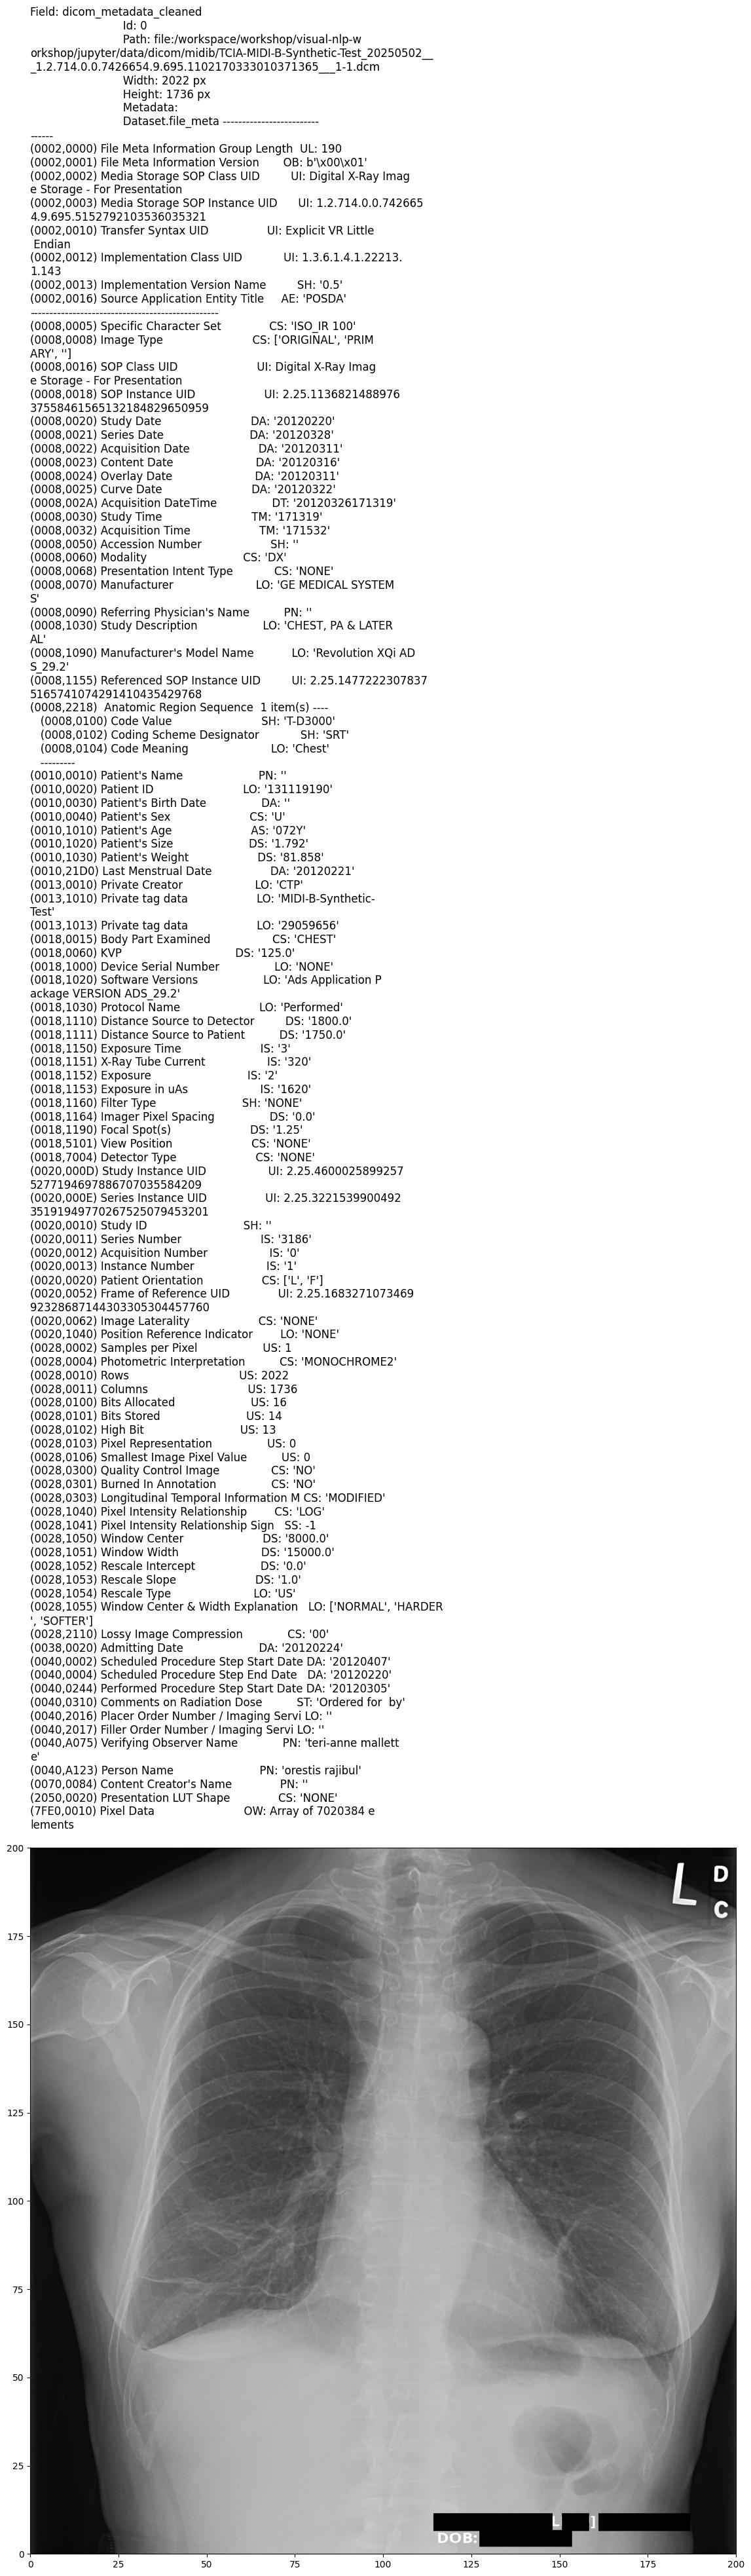

/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: Invalid value for VR UI: '2.3.185.0.2.0801206.6.512.1221786140775342924'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)


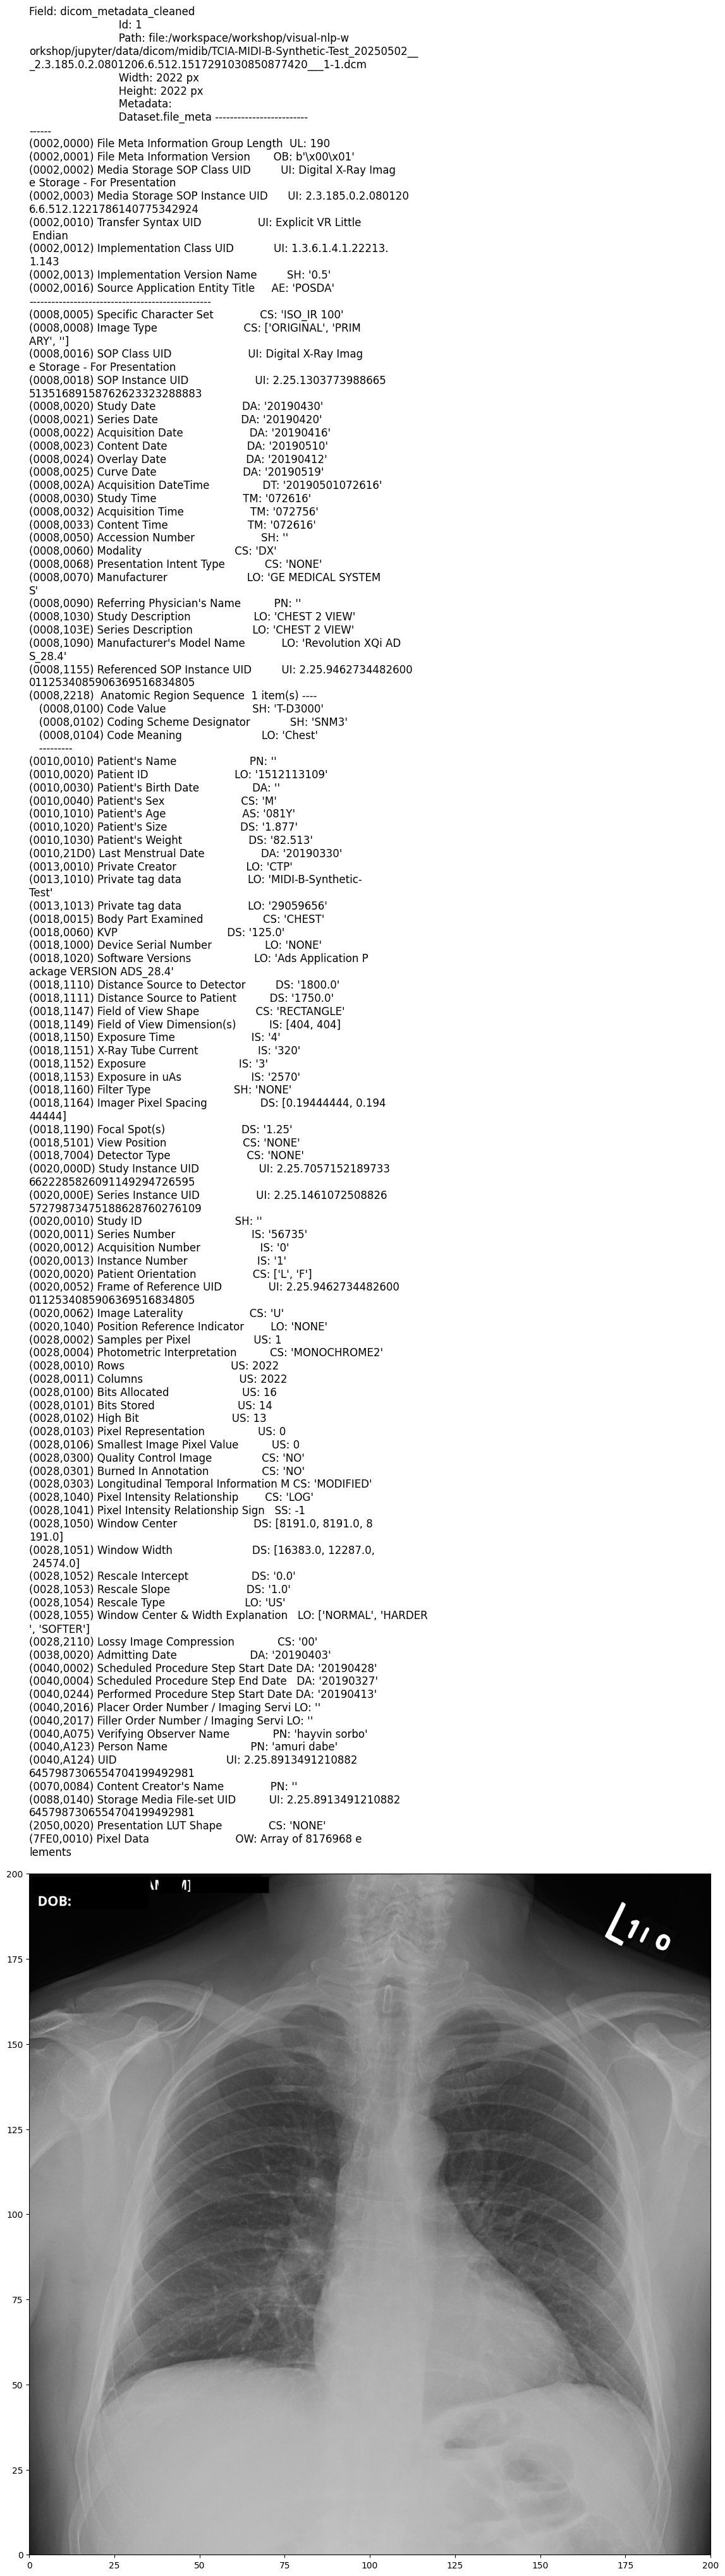

In [24]:
display_dicom(df=res_df, fields="dicom_metadata_cleaned", limit_frame=1, show_meta=True)

### Extract Original Vs Cleaned Metadata to Pandas DF

In [25]:
collect_result = []

for item in res_df.select("path", "metadata_original", "metadata_final").toLocalIterator():

    data = item.asDict()

    metadata_original = json.loads(data["metadata_original"])
    metadata_final = json.loads(data["metadata_final"])

    for item in metadata_original.keys():
        original_value = metadata_original[item]["value"]
        cleaned_value = metadata_final[item]["value"]
        
        value_changed = False if original_value == cleaned_value else True
        
        collect_result.append([data["path"], item, metadata_original[item]["vr"], original_value, cleaned_value, value_changed])

In [26]:
columns = ["File", "Tag", "VR", "Original_Value", "Cleaned_Value", "Is_Changed"]

metadata_result_df = pd.DataFrame(collect_result, columns=columns)
metadata_result_df.head(5)

File       Tag  VR  \
0  file:/workspace/workshop/visual-nlp-workshop/j...  00080005  CS   
1  file:/workspace/workshop/visual-nlp-workshop/j...  00080008  CS   
2  file:/workspace/workshop/visual-nlp-workshop/j...  00080016  UI   
3  file:/workspace/workshop/visual-nlp-workshop/j...  00080018  UI   
4  file:/workspace/workshop/visual-nlp-workshop/j...  00080020  DA   

                                  Original_Value  \
0                                     ISO_IR 100   
1                          [ORIGINAL, PRIMARY, ]   
2                    1.2.840.10008.5.1.4.1.1.1.1   
3  1.2.714.0.0.7426654.9.695.5152792103536035321   
4                                       20120413   

                                  Cleaned_Value  Is_Changed  
0                                    ISO_IR 100       False  
1                         [ORIGINAL, PRIMARY, ]       False  
2                   1.2.840.10008.5.1.4.1.1.1.1       False  
3  2.25.113682148897637558461565132184829650959        True  
4                                      20120220        True

### Filter All Tags That are DeIdentified

In [27]:
metadata_result_df[metadata_result_df["Is_Changed"] == True].head(5)

File       Tag  VR  \
3  file:/workspace/workshop/visual-nlp-workshop/j...  00080018  UI   
4  file:/workspace/workshop/visual-nlp-workshop/j...  00080020  DA   
5  file:/workspace/workshop/visual-nlp-workshop/j...  00080021  DA   
6  file:/workspace/workshop/visual-nlp-workshop/j...  00080022  DA   
7  file:/workspace/workshop/visual-nlp-workshop/j...  00080023  DA   

                                  Original_Value  \
3  1.2.714.0.0.7426654.9.695.5152792103536035321   
4                                       20120413   
5                                       20120413   
6                                       20120413   
7                                       20120413   

                                  Cleaned_Value  Is_Changed  
3  2.25.113682148897637558461565132184829650959        True  
4                                      20120220        True  
5                                      20120328        True  
6                                      20120311        True  
7                                      20120316        True

## Extract UID/Patiend ID Mapping

In [28]:
from sparkocr.utils import generate_dicom_mapping

help(generate_dicom_mapping)

Help on function generate_dicom_mapping in module sparkocr.utils:

generate_dicom_mapping(df, original_col, final_col)
    Return mapping of old and new dicom identifiers.
    
    :param df : Dataframe containing original and cleaned metadata
    :param original_col : Dataframe column containing original metadata
    :param final_col : Dataframe column containing cleaned metadata
    :return {"uid_mapping" : {old_uid:new_uid}, "patient_mapping" : {old_patid:new_patid}



In [29]:
mapping_result = generate_dicom_mapping(res_df, "metadata_original", "metadata_final")

columns = ["id_old", "id_new"]

uid_mapping = pd.DataFrame(list(mapping_result["uid_mapping"].items()), columns=columns)

uid_mapping.head(5)

id_old  \
0                    1.2.840.10008.5.1.4.1.1.1.1   
1  1.2.714.0.0.7426654.9.695.5152792103536035321   
2  1.2.714.0.0.7426654.9.695.1530417802811153775   
3  1.2.714.0.0.7426654.9.695.7173207380656716992   
4  1.2.714.0.0.7426654.9.695.1102170333010371365   

                                         id_new  
0                   1.2.840.10008.5.1.4.1.1.1.1  
1  2.25.113682148897637558461565132184829650959  
2   2.25.14772223078375165741074291410435429768  
3   2.25.46000258992575277194697886707035584209  
4  2.25.322153990049235191949770267525079453201

In [30]:
columns = ["id_old", "id_new"]

patient_mapping = pd.DataFrame(list(mapping_result["patient_mapping"].items()), columns=columns)

patient_mapping.head(20)

id_old      id_new
0   913829086   131119190
1  2063640840  1512113109

## Save Dicom File To Disk

In [31]:
root_path = "./dicom_deid_output"

os.makedirs(root_path, exist_ok=True)

for item in res_df.select("path", "dicom_metadata_cleaned").toLocalIterator():
    data = item.asDict()
    filename = os.path.basename(data["path"])

    file_out_path = os.path.join(root_path, filename)

    with open(file_out_path, "wb") as dicom_out:
        dicom_out.write(data["dicom_metadata_cleaned"])

In [32]:
shutil.rmtree(root_path)
shutil.rmtree("./dicom_pixels_ner/")